In [1]:
import time
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [3]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)

Files already downloaded and verified


In [4]:
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

Files already downloaded and verified


In [5]:
img, _ = train_set[0]

# Sieć konwolucyjna

## Padding

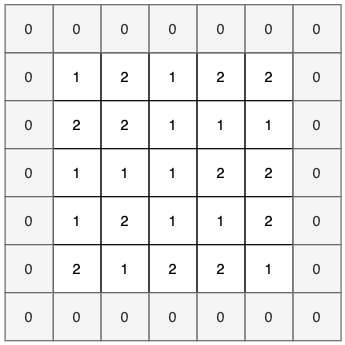

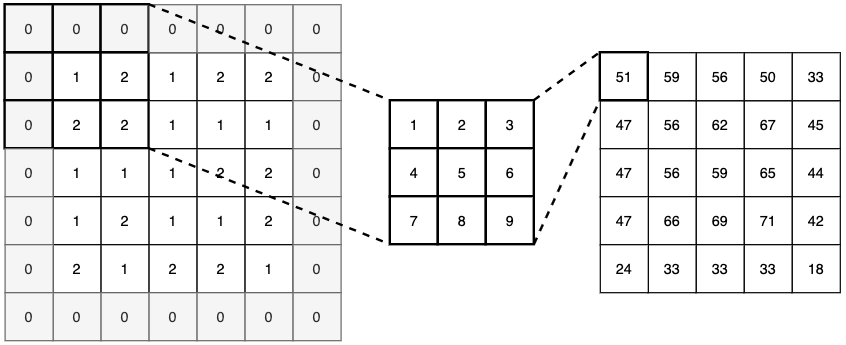

In [6]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

In [7]:
out = conv(img.unsqueeze(0))

In [8]:
img.unsqueeze(0).shape, out.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def imshow(img):
    plt.imshow(img, cmap="gray")
    plt.show()

In [10]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0 / 9.0)

In [11]:
out = conv(img.unsqueeze(0))

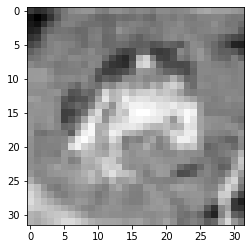

In [12]:
imshow(img[0])

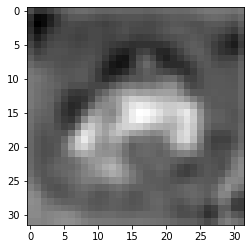

In [13]:
imshow(out[0, 0].detach())

In [14]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0], 
                                   [-1.0, 0.0, 1.0], 
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [15]:
out = conv(img.unsqueeze(0))

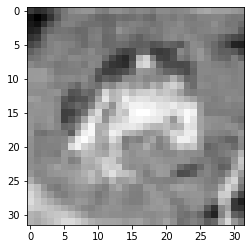

In [16]:
imshow(img[0])

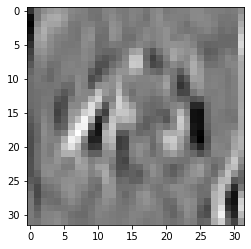

In [17]:
imshow(out[0, 0].detach())

## Max pooling

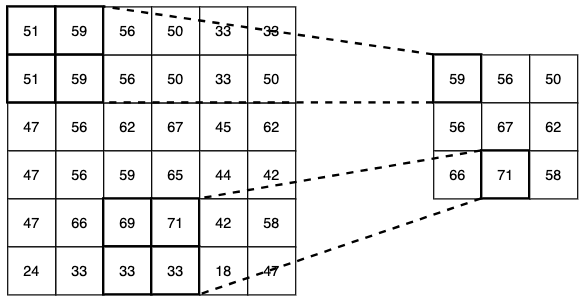

In [18]:
pool = nn.MaxPool2d(2)

In [19]:
out = pool(img.unsqueeze(0))

In [20]:
img.unsqueeze(0).shape, out.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

## Sieć konwolucyjna

In [21]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), 
    nn.Tanh(), 
    nn.MaxPool2d(2), 
    nn.Conv2d(16, 8, kernel_size=3, padding=1), 
    nn.Tanh(), 
    nn.MaxPool2d(2), 
    nn.Linear(8 * 8 * 8, 10)
)

In [22]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

6738

In [23]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(8 * 8 * 8, 10)
    
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.reshape(-1, 8 * 8 * 8)
        out = self.fc(out)
        return out

In [24]:
model = ConvNet()

In [25]:
sum([p.numel() for p in model.parameters() if p.requires_grad])

6738

In [26]:
def training_loop(n_epochs, optimizer, model, criterion, train_loader):
    start = time.time()
    for epoch in range(n_epochs):
        losses = []
        
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f"Epoch: {epoch}; loss: {sum(losses)/len(losses)}")
    end = time.time()
    print(f"Czas: {round(end - start)} s")

In [27]:
learning_rate = 0.001
n_epochs = 150

In [28]:
model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [33]:
training_loop(n_epochs=n_epochs, optimizer=optimizer, model=model, 
              criterion=criterion, train_loader=train_loader)

Epoch: 0; loss: 2.284116845606538
Epoch: 1; loss: 2.1899413855179497
Epoch: 2; loss: 2.076509433939024
Epoch: 3; loss: 2.0097224500478075
Epoch: 4; loss: 1.967377286128071
Epoch: 5; loss: 1.9370888518860272
Epoch: 6; loss: 1.9115261760209223
Epoch: 7; loss: 1.888223302638744
Epoch: 8; loss: 1.8653187931651045
Epoch: 9; loss: 1.8420065411216462
Epoch: 10; loss: 1.8177442355534
Epoch: 11; loss: 1.7917702333701542
Epoch: 12; loss: 1.7668524716821168
Epoch: 13; loss: 1.7436511922065558
Epoch: 14; loss: 1.7228332102451178
Epoch: 15; loss: 1.7052074660120717
Epoch: 16; loss: 1.6891737958354414
Epoch: 17; loss: 1.6747882908872327
Epoch: 18; loss: 1.6610027952572268
Epoch: 19; loss: 1.6486272761583938
Epoch: 20; loss: 1.6364838785832496
Epoch: 21; loss: 1.6255586321091713
Epoch: 22; loss: 1.6138682903536141
Epoch: 23; loss: 1.6038803074061108
Epoch: 24; loss: 1.5932316162702067
Epoch: 25; loss: 1.5848681925202879
Epoch: 26; loss: 1.5756513230940874
Epoch: 27; loss: 1.567442336503197
Epoch: 28;

In [34]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for xs, ys in data_loader:
            scores = model(xs)
            _, predictions = torch.max(scores, dim=1)
            correct += (predictions == ys).sum()
            total += ys.shape[0]

        acc = float(correct) / float(total) * 100
        print(f"accuracy: {acc:.2f}")

In [35]:
get_accuracy(model, train_loader)

accuracy: 59.50


In [36]:
get_accuracy(model, test_loader)

accuracy: 58.14
